# PCA Analysis

## 1. Loading and preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA

In [2]:
filename = f'../data/signature_x1_L15_W3_20250324_190419.csv' # adjust to desired file

# Load the DataFrame from the CSV file
sig_df = pd.read_csv(filename)

# Load depth information
depth_df = pd.read_csv('../data/external/trefoil_list.csv')

# Merge dataframes
df = pd.merge(sig_df, depth_df, on='Chain')
# print(df.head(1))

# extract parameters from filename
import re
match = re.search(r'L(\d+)_W(\d+)', filename)
if match:
    trunc_level = int(match.group(1)) 
    sig_weight = int(match.group(2))   
else:
    raise ValueError("Filename format incorrect - missing L/W parameters")

print(f"trunc_level: {trunc_level}, sig_weight: {sig_weight}")

# Classify depths
df['depth_class'] = pd.cut(df['Depth'],
                          bins=[-np.inf, 0.005, 0.05, np.inf],
                          labels=['shallow', 'neither', 'deep'])
# Select signature data fram df
X = df.drop(columns=['Landscape', 'Chain', 'Depth', 'Length', 'N-tail', 'C-tail', 'Representative', 'depth_class'])

# Standardize features (PCA is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

trunc_level: 15, sig_weight: 3


## 2. Compute PCA

In [3]:
# Fit PCA (reduce to 2-3 components for visualization)
pca = PCA(n_components=10)  # Adjust if needed
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9','PC10'])
pca_df['Depth'] = df['Depth']  # Add metadata (optional)
pca_df['Representative'] = df['Representative']  # e.g., knot types
pca_df['Depth_class'] = df['depth_class']

In [4]:
print(f"Variance explained by each PC: {pca.explained_variance_ratio_}")

Variance explained by each PC: [0.41185421 0.2486485  0.04756353 0.04180539 0.03215942 0.0266698
 0.01590945 0.01297189 0.01098335 0.0096273 ]


## 3. Visualize results colored by depth

### 3.1. PC 1 and 2 colored by depth classification 

In [5]:
# Custom color scheme
color_map = {
    'deep': '#A7F432',    # lime green
    'shallow': '#FFB6C1', # pastel pink
    'neither': '#D3D3D3'  # light grey
}

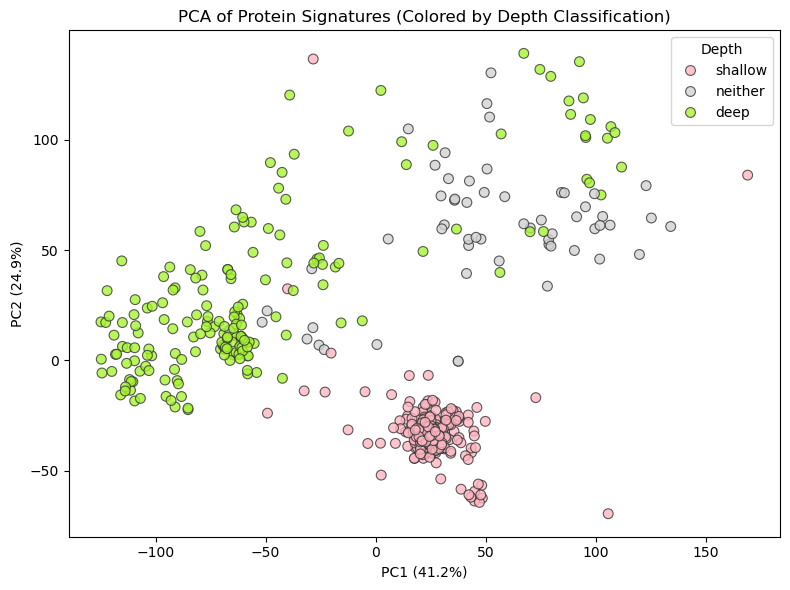

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Depth_class',
    palette=color_map,
    s=50,
    alpha=0.8,
    edgecolor='#333333',
    linewidth=0.8
)
plt.title('PCA of Protein Signatures (Colored by Depth Classification)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend(title='Depth')
# plt.show()
# save fig
plt.tight_layout()
# Human-readable date (e.g., "21May2024")
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)
filename = (
    f"../results/fig/pca_2PC_colored_by_depth_class_L{trunc_level}_W{sig_weight}_"
    f"{date_str}.png"
)
plt.savefig(filename, dpi=300, bbox_inches='tight')

### 3.2. PC 1 and 2 colored by depth value

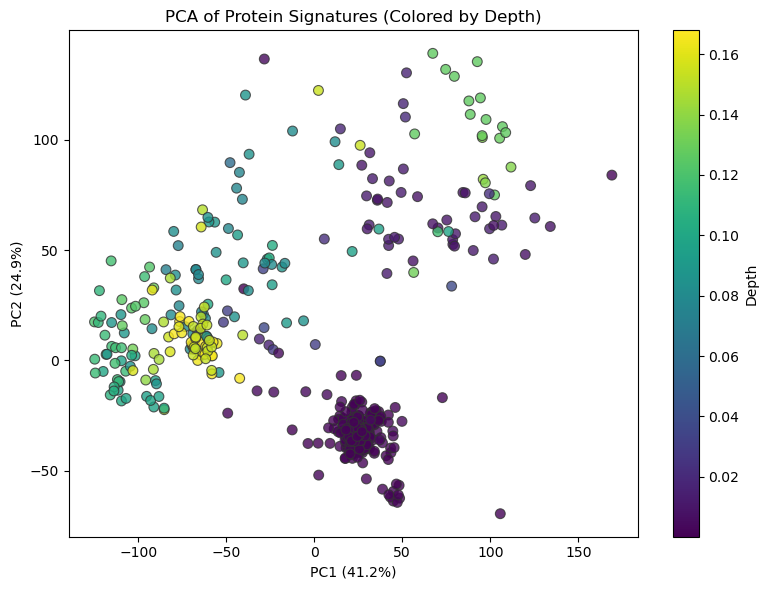

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Depth',
    palette='viridis',
    hue_norm=(pca_df['Depth'].min(), pca_df['Depth'].max()),  # Ensures continuous scaling
    s=50,
    alpha=0.8,
    edgecolor='#333333',
    linewidth=0.8,
    legend=False,
)
plt.title('PCA of Protein Signatures (Colored by Depth)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
# plt.legend(title='Depth')
norm = plt.Normalize(pca_df['Depth'].min(), pca_df['Depth'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Depth', ax=plt.gca())  # Explicit colorbar
# plt.show()
# save fig
plt.tight_layout()
# Human-readable date (e.g., "21May2024")
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)
filename = (
    f"../results/fig/pca_2PC_colored_by_depth_value_L{trunc_level}_W{sig_weight}_"
    f"{date_str}.png"
)
plt.savefig(filename, dpi=300, bbox_inches='tight')

### 3.3. PC 1, 2 and 3 colored by depth class

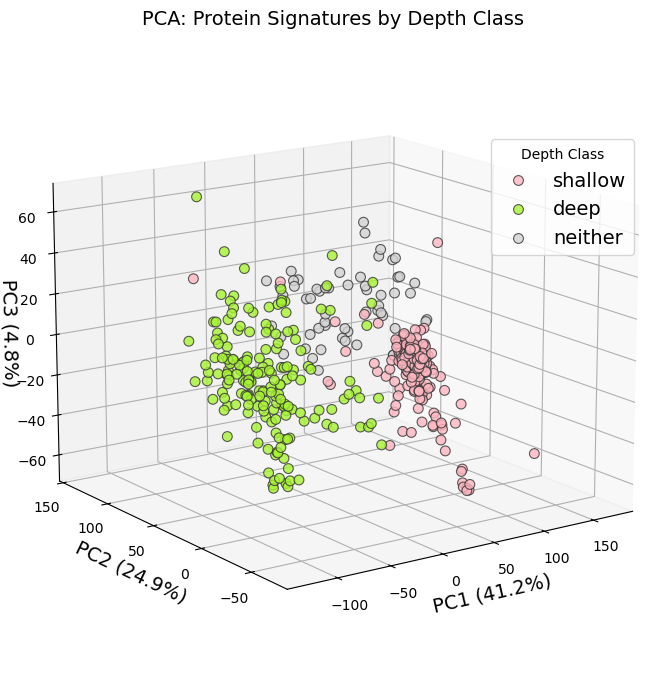

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each category separately
for depth_class in ['shallow', 'deep', 'neither']:
    subset = pca_df[pca_df['Depth_class'] == depth_class]
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        label=depth_class,
        color=color_map[depth_class],
        s=50,
        alpha=0.8,
        edgecolor='#333333',
    linewidth=0.8
    )

# Add legend and labels
ax.legend(title='Depth Class', fontsize =14, loc='upper right',bbox_to_anchor=(0.98, 0.85))
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize =14)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize =14)
# ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', fontsize =14)
plt.title('PCA: Protein Signatures by Depth Class', fontsize =14)
# Adjust subplot margins to make room for labels
plt.subplots_adjust(left=0.2, right=1, bottom=0, top=1)

# Set labels with padding for the z-axis
# ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', labelpad=10)
# ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', labelpad=10)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', labelpad=-.5, fontsize =14)  # Extra padding for z-axis

# Rotate the view for better visibility (optional)
ax.view_init(elev=15, azim=235)  # Adjust angles as needed

# plt.title('3D PCA: Protein Signatures by Depth Class', pad=1)
plt.tight_layout()
# plt.show()
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)
filename = (
    f"../results/fig/pca_3PC_colored_by_depth_class_L{trunc_level}_W{sig_weight}_"
    f"{date_str}.png"
)
# plt.savefig(filename, dpi=300, bbox_inches='tight')

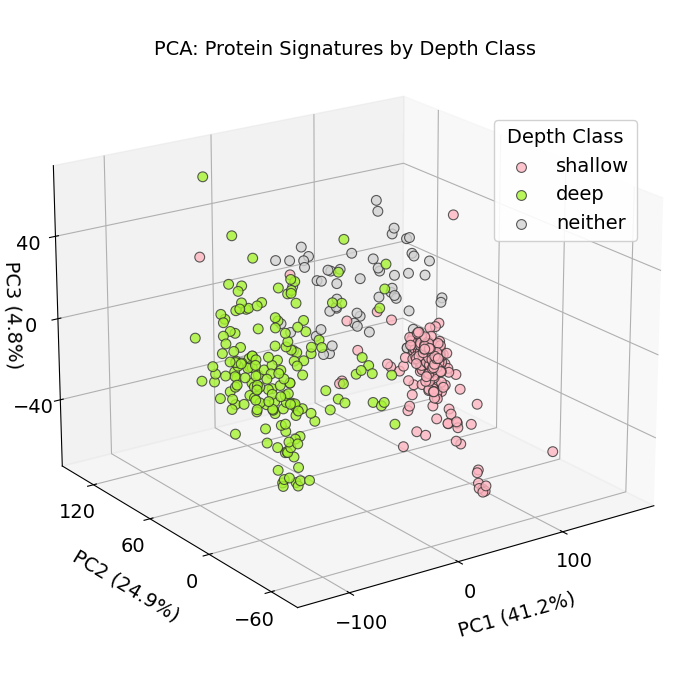

In [83]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with adjusted proportions
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each category with consistent styling
for depth_class in ['shallow', 'deep', 'neither']:
    subset = pca_df[pca_df['Depth_class'] == depth_class]
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        label=depth_class,
        color=color_map[depth_class],
        s=50,
        alpha=0.8,
        edgecolor='#333333',
        linewidth=0.8
    )

# Axis labels with variance percentages and proper padding
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', 
              fontsize=14, labelpad=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', 
              fontsize=14, labelpad=12)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', 
              fontsize=14, labelpad=-1.5)  # Increased padding

# Reduce number of ticks on all axes
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.set_major_locator(plt.MaxNLocator(4))  # Show only 4 ticks per axis
    axis.set_tick_params(labelsize=14)  # Uniform tick label size

# Legend with consistent font sizes
legend = ax.legend(title='Depth Class', 
                  fontsize=14,
                  title_fontsize=14,
                  loc='upper right',
                  bbox_to_anchor=(0.95, 0.85),  # Adjusted position
                  framealpha=0.9)

# Title positioning - moved down closer to plot
plt.title('PCA: Protein Signatures by Depth Class', 
          fontsize=14, y=1.0)  # y parameter controls vertical position

# Adjust the plot position within the figure
# plt.subplots_adjust(left=0.5,  # More space on left for z-label
#                    right=0.85,  # Shift plot right
#                    bottom=0.1, 
#                    top=0.85,   # Reduced top space
#                    wspace=0.3)

# Set better viewing angle
ax.view_init(elev=20, azim=235)  # Slightly adjusted for better z-axis visibility

# Ensure z-label isn't cropped
ax.zaxis.label.set_visible(True)
ax.zaxis.set_rotate_label(True)  # Keep z-label horizontal

# Final render
plt.tight_layout()

# Save with high resolution
date_str = datetime.now().strftime("%d%b%Y")
filename = (
    f"../results/fig/pca_3PC_colored_by_depth_class_L{trunc_level}_W{sig_weight}_"
    f"{date_str}.png"
)
plt.savefig(filename, dpi=300, bbox_inches='tight')
# plt.close()

### 3.4. PC 1, 2 and 3 colored by depth value

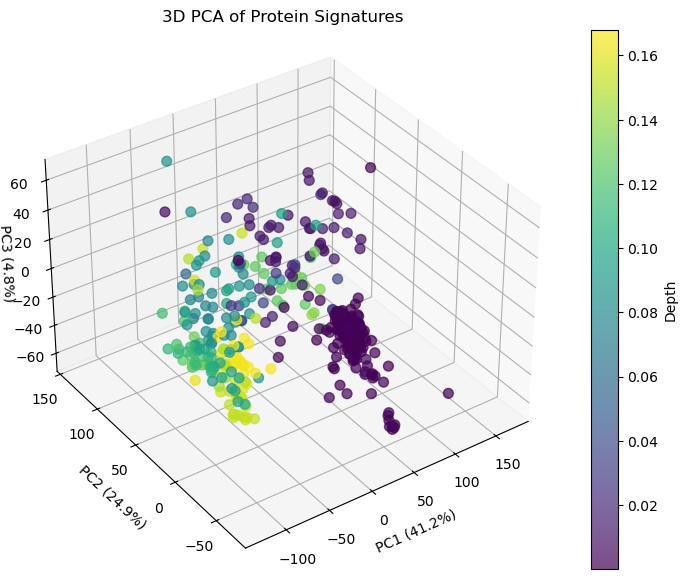

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    pca_df['PC3'],
    c=pca_df['Depth'],
    cmap='viridis',
    s=50,
    alpha=0.7
)
plt.colorbar(sc, label='Depth')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
# Rotate the view for better visibility (optional)
ax.view_init(elev=35, azim=235)  # Adjust angles as needed
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', labelpad=-1.9)  # Extra padding for z-axis
plt.title('3D PCA of Protein Signatures')
# plt.show()
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)
filename = (
    f"../results/fig/pca_3PC_colored_by_depth_L{trunc_level}_W{sig_weight}_"
    f"{date_str}.png"
)
plt.savefig(filename, dpi=300, bbox_inches='tight')

## 4. Visualize results colored by representatives

In [60]:
Y = pca_df[~(pca_df['Representative']=='Other')]

In [61]:
Y = Y.drop(columns=[ 'Depth'])

In [58]:
# Custom color scheme
rep_classes = ['4qef_A', '1fug_A', '1j85_A', '1uak_A', 
               '3znc_A', '2v3j_A', '3kzk_A', '6qqw_A', '6rqq_A']
rep_colors = [
    '#1A4B8C',  # denim blue (4qef_A)
    '#B784A7',  # mauve (1fug_A)
    '#FF69B4',  # BRIGHT PINK (1j85_A) - changed from #FFC0CB
    '#228B22',  # green (1uak_A)
    '#FFA500',  # orange (3znc_A)
    '#FF0000',  # red (2v3j_A)
    '#87CEEB',  # sky blue (3kzk_A)
    '#FFFF00',  # yellow (6qqw_A)
    '#2A0A5E'   # dark blue-violet (6rqq_A)
]
rep_color_dict = dict(zip(rep_classes, rep_colors))

### 4.1. PC's 1 and 2 

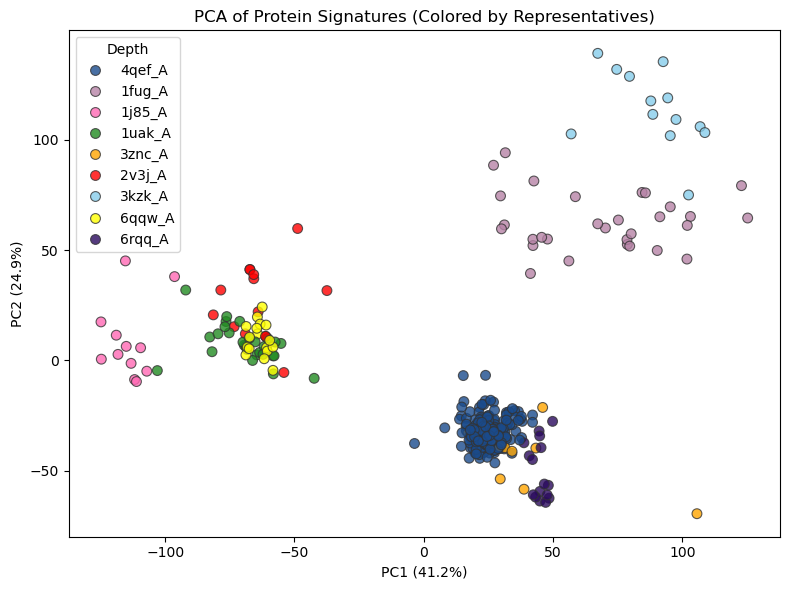

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=Y,
    x='PC1',
    y='PC2',
    # hue='Depth',  # or 'Label'
    # hue='Depth_class',
    hue='Representative',
    # palette='viridis',
    palette=rep_color_dict,
    s=50,
    alpha=0.8,
    edgecolor='#333333',
    linewidth=0.8
)
plt.title('PCA of Protein Signatures (Colored by Representatives)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend(title='Depth')
# plt.show()
# save fig
plt.tight_layout()
# Human-readable date (e.g., "21May2024")
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)
filename = (
    f"../results/fig/pca_2PC_colored_by_representative_L{trunc_level}_W{sig_weight}_"
    f"{date_str}.png"
)
plt.savefig(filename, dpi=300, bbox_inches='tight')

### 4.2. PC's 1, 2 and 3

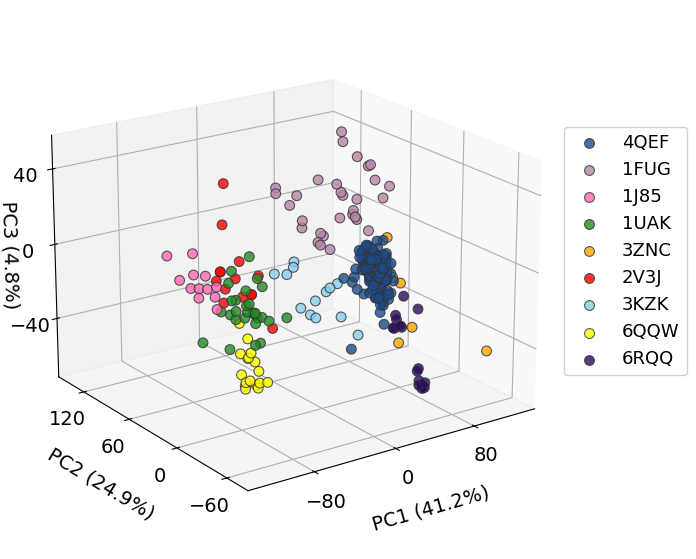

In [93]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each category separately
for rep in rep_classes:
    subset =Y[Y['Representative'] == rep]
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        label=rep.replace("_A","").upper(),
        color=rep_color_dict[rep],
        s=50,
        alpha=0.8,
        edgecolor='#333333',
    linewidth=0.8
    )

# Add legend and labels
ax.legend(title='Representative Class')
# Adjust subplot margins to make room for labels
# plt.subplots_adjust(left=1, right=1.1, bottom=0.1, top=0.2)

# Axis labels with variance percentages and proper padding
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', 
              fontsize=14, labelpad=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', 
              fontsize=14, labelpad=12)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', 
              fontsize=14, labelpad=-1.5)  # Increased padding

# Reduce number of ticks on all axes
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.set_major_locator(plt.MaxNLocator(4))  # Show only 4 ticks per axis
    axis.set_tick_params(labelsize=14)  # Uniform tick label size

# Legend with consistent font sizes
legend = ax.legend(title='', 
                  fontsize=13,
                  title_fontsize=14,
                  loc='upper right',
                  bbox_to_anchor=(1.26, 0.8),  # Adjusted position
                  framealpha=0.9)

# Title positioning - moved down closer to plot
# plt.title('PCA: Protein Signatures by Representative', 
          # fontsize=14, y=1.0)  # y parameter controls vertical position

# Rotate the view for better visibility (optional)
ax.view_init(elev=20, azim=235)  # Adjust angles as needed

# plt.title('3D PCA: Protein Signatures by Depth Class', pad=1)
# plt.tight_layout()
# plt.show()
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)
filename = (
    f"../results/fig/pca_3PC_colored_by_representative_L{trunc_level}_W{sig_weight}_{date_str}.png"
)
plt.savefig(filename, dpi=300, bbox_inches='tight')

Let's do both of the main plots (on the paper) on a single figure

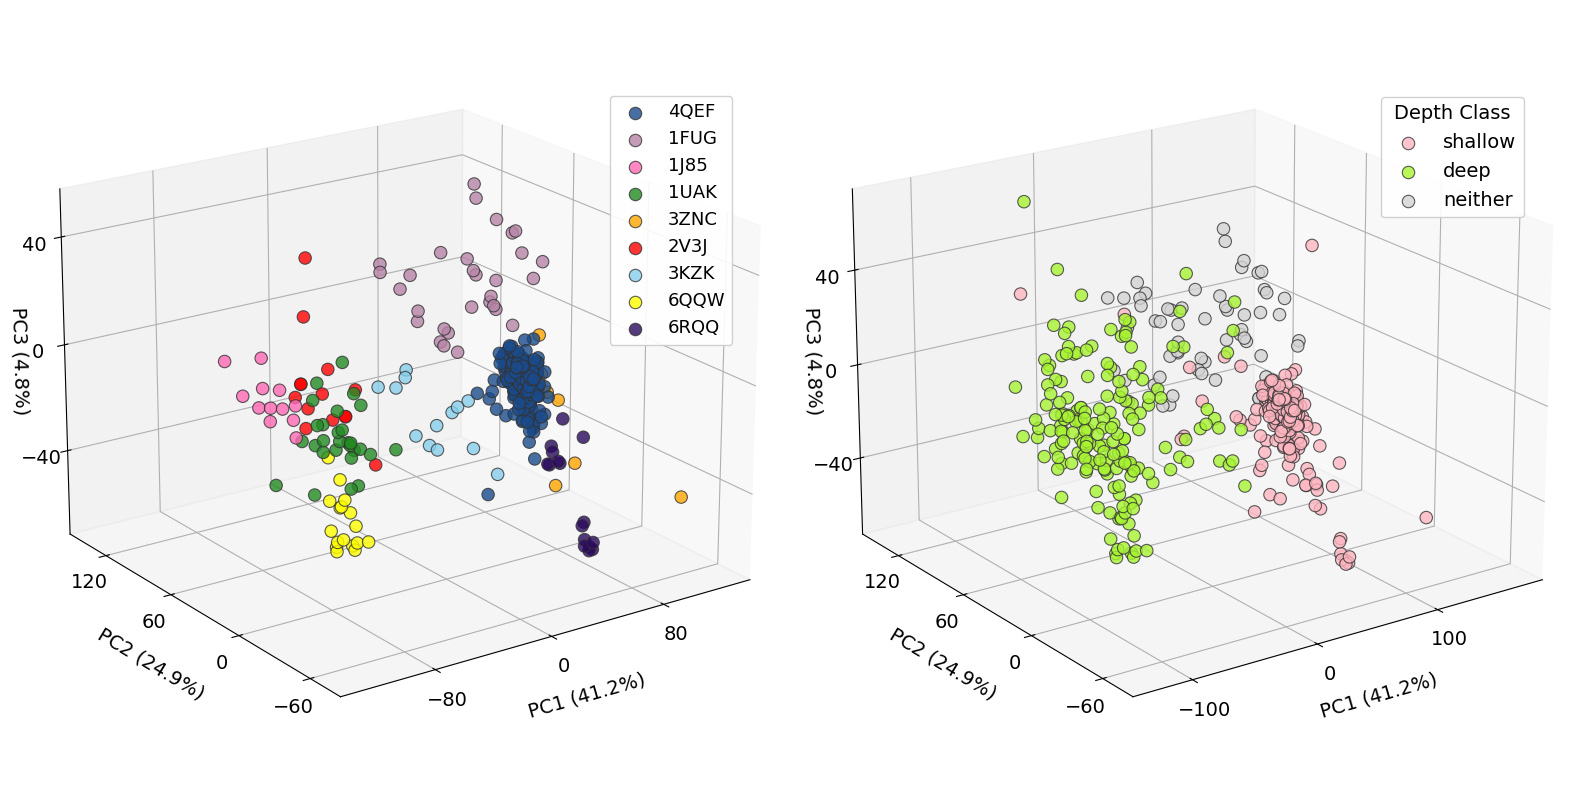

In [109]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8),  # Wider figure for side-by-side
                               subplot_kw={'projection': '3d'})

# Plot each category separately
for rep in rep_classes:
    subset =Y[Y['Representative'] == rep]
    ax1.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        label=rep.replace("_A","").upper(),
        color=rep_color_dict[rep],
        s=80,
        alpha=0.8,
        edgecolor='#333333',
    linewidth=0.8
    )

# Add legend and labels
ax1.legend(title='Representative Class')
# Adjust subplot margins to make room for labels
# plt.subplots_adjust(left=1, right=1.1, bottom=0.1, top=0.2)

# Axis labels with variance percentages and proper padding
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', 
              fontsize=14, labelpad=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', 
              fontsize=14, labelpad=12)
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', 
              fontsize=14, labelpad=-1.5)  # Increased padding

# Reduce number of ticks on all axes
for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
    axis.set_major_locator(plt.MaxNLocator(4))  # Show only 4 ticks per axis
    axis.set_tick_params(labelsize=14)  # Uniform tick label size

# Legend with consistent font sizes
legend1 = ax1.legend(title='', 
                  fontsize=13,
                  title_fontsize=14,
                  loc='upper right',
                  bbox_to_anchor=(.95, 0.9),  # Adjusted position
                  framealpha=0.9)

# Title positioning - moved down closer to plot
# plt.title('PCA: Protein Signatures by Representative', 
          # fontsize=14, y=1.0)  # y parameter controls vertical position

# Rotate the view for better visibility (optional)
ax1.view_init(elev=20, azim=235)  # Adjust angles as needed

# now plot 2

# Plot each category with consistent styling
for depth_class in ['shallow', 'deep', 'neither']:
    subset = pca_df[pca_df['Depth_class'] == depth_class]
    ax2.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        label=depth_class,
        color=color_map[depth_class],
        s=80,
        alpha=0.8,
        edgecolor='#333333',
        linewidth=0.8
    )

# Axis labels with variance percentages and proper padding
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', 
              fontsize=14, labelpad=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', 
              fontsize=14, labelpad=12)
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', 
              fontsize=14, labelpad=-1.5)  # Increased padding

# Reduce number of ticks on all axes
for axis in [ax2.xaxis, ax2.yaxis, ax2.zaxis]:
    axis.set_major_locator(plt.MaxNLocator(4))  # Show only 4 ticks per axis
    axis.set_tick_params(labelsize=14)  # Uniform tick label size

# Legend with consistent font sizes
legend2 = ax2.legend(title='Depth Class', 
                  fontsize=14,
                  title_fontsize=14,
                  loc='upper right',
                  bbox_to_anchor=(.95, .9),  # Adjusted position
                  framealpha=0.9)

# Set better viewing angle
ax2.view_init(elev=20, azim=235)  # Slightly adjusted for better z-axis visibility

# Ensure z-label isn't cropped
ax2.zaxis.label.set_visible(True)
ax2.zaxis.set_rotate_label(True)  # Keep z-label horizontal

# Final render
plt.tight_layout()

# Save with high resolution
date_str = datetime.now().strftime("%d%b%Y")
filename = (
    f"../results/fig/pca_3PC_both_plots_L{trunc_level}_W{sig_weight}_"
    f"{date_str}.png"
)
plt.savefig(filename, dpi=300, bbox_inches='tight')
# plt.close()